# Project waitingTimePrediction changed to nbOfTick within frame prediction

Disclaimer: 

CPU : i7-7700k - 4.5Ghz Overclocked

GPU : Nvidia 1080ti

RAM : 32Go

SSD : 2X250Go

No issue of memory with this configuration
The Data itself, weights more than 2To uncompressed. 

In [26]:
#imports
import json
from pprint import pprint
import scipy.optimize as optimize
import pandas as pd
import numpy as np
from datetime import datetime
from enum import Enum
import sys
import timeit
import matplotlib.pyplot as plt
import datetime as dt
import calendar
from dateutil import tz
import gzip
from pathlib import Path
# import L4.L4 as L4

# from pandas.plotting import parallel_coordinates
# from sklearn.mixture import GaussianMixture as GMM
# from sklearn.metrics import silhouette_score
# from sklearn.cluster import KMeans
plt.style.use('seaborn')

In [27]:
#we need to preprocess the data
def getBookContract(aStringNumberContract, aTypeOption):
    aContract = ''
    if aStringNumberContract == "000" and aTypeOption == "1":
        aContract = CONTRACTTYPE.FUTURE #replace with enums
    elif aTypeOption == "2":
        aContract = CONTRACTTYPE.CALL 
    elif aTypeOption == "3":
        aContract = CONTRACTTYPE.PUT 
    else:
        print("error, Contract Type" + str(aStringNumberContract) + " , " + str(aTypeOption) + " not recognized")
    
    return aContract

class CONTRACTTYPE(Enum):
    UNSET = 0
    FUTURE = 1
    CALL = 2
    PUT = 3

In [28]:

def getExpiryDate(aBook):
    anExpiryCode  = aBook[6:8]
    #hardcoded version for now. 
    myString_date = ''
    
    myString_year = ''
    myString_month = ''
    myString_day = ''
    
    #get year code
    if anExpiryCode[0] == 'L':
        myString_year = "2016"
    elif anExpiryCode[0] == 'M':
        myString_year = "2017"
    elif anExpiryCode[0] == 'N':
        myString_year = "2018"
    elif anExpiryCode[0] == 'P': #It looks strange, but that's KRX 
        myString_year = "2019"
    else : 
        sys.stderr.write("fatal error\n expiry year code unknown \n")
    
    #get month code
    myPotentialMonths = ['','1','2','3','4','5','6','7','8','9','A','B','C']

    if anExpiryCode[1] in myPotentialMonths:
        myString_month =  str(myPotentialMonths.index(anExpiryCode[1]))
    else : 
        sys.stderr.write("fatal error\n expiry month code unknown \n")    
    
    if myString_month == '':
        sys.stderr.write("fatal error\n expiry month code unknown \n")   
    #get day
    #get third Wednesday of every month, we will have to make bank holidays exceptions
    myString_day = str(calendar.Calendar(2).monthdatescalendar(int(myString_year), \
                                                               int(myString_month))[3][0].day)
    
#     print(myString_month)                   
    myString_date = myString_year+'-'+myString_month+'-'+myString_day+' 16:00:00'

    timeZone = tz.gettz('Asia/Seoul')
            
    #print("Don't forget bank holidays exceptions")
    return datetime.strptime(myString_date, "%Y-%m-%d %H:%M:%S").replace(tzinfo=timeZone).astimezone(timeZone)


In [29]:
#get the right time for plotting later
def utcToRightTMZ(aUTCTMZ):
    
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('Asia/Seoul')
    
    aUTCTMZ = aUTCTMZ.replace(tzinfo=from_zone)
    localTimeStamp = aUTCTMZ.astimezone(to_zone)
    
    return localTimeStamp

# Load Data

In [227]:
def inStrikeRange(aFutBook, aOptBook):
    '''
    look at slightly OTM or ITM options and keep that range static. Change dynamically book to keep that range
    '''
    if aFutBook == '' or aOptBook == '': #if the fut book is not itialized
        return False
    elif getBookContract(aOptBook[8:11],aOptBook[3]) is not CONTRACTTYPE.CALL : #only if Call
        return False
    
    return ((int(aOptBook[8:11]) > int(5 * np.floor((aFutBook['bid_price_0']+ aFutBook['ask_price_0'])/2/5))-5 )
    and (int(aOptBook[8:11]) < int(5 * np.ceil((aFutBook['bid_price_0']+ aFutBook['ask_price_0'])/2/5))+11))

def extractInterestingData(nbOfDataPoints_, aOptionStrike,data_):
    '''
    aOptionStrike: enables to initialize the book to start with
    '''
    myTicksOfInterest = np.empty(shape = (0,0))
    myCounter = 0
    myLastVol = 0
    myLastVolFut = 0
    timeOfTradeFut = 0
    myFutPrice = 0
    myDTM = -1 #dayToMaturity
    
    myFirstFut = True
    myFirstOpt = True
    myFutBook = ''
    myFutTick = ''
    myOptionBook = ''
    myPastOptionBook = ''
    myTimeList = [] #faster than nparray for appending
    myYTimeList = []
    
    myUpperCounter = -1 #future prediction
    myLowerCounter = 0
    Ys = [] #to predict
    
    for idx, tick in enumerate(data_):
        myBook =tick["book"]
        if myBook[5] == '1':   #it as to be a MAXI
            myTickCreatedTime = tick['created']/1000000 #vastly reused in the code
            TTM = (getExpiryDate(myBook) - utcToRightTMZ(datetime.utcfromtimestamp(myTickCreatedTime))).total_seconds()/3600/24    
#             test.append(TTM)
#             print(getBookContract(myBook[8:11],myBook[3]))
#             print(TTM)
            if(getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.FUTURE) and TTM<90 :
#                 print('1')
                if tick['type']=='lastdone' : 
#                     print('2')
                    if myFirstFut:
                        myFutBook = myBook
                        myFirstFut = False

                    if myFutBook == myBook:
                        myLastVolFut = (0.995*myLastVol + 0.001*(tick['volume']))
                        timeOfTradeFut = utcToRightTMZ(datetime.utcfromtimestamp(myTickCreatedTime))
                        myFutPrice = tick['price']
                else:
                    myFutTick = tick
#             print(inStrikeRange(myFutTick, myBook))        
            if not myFirstFut and inStrikeRange(myFutTick, myBook) and (myDTM==np.floor(TTM) or myDTM==-1) and TTM<30: #this also checks if is CALL
#                 print('3')
                    #we need to go through a first future to calculate the moneyness
                    #range we accept to look at a product (keep it not too small or it will always change book)
                myFutMid = (myFutTick['bid_price_0']+ myFutTick['ask_price_0'])/2
                #check for not initialized book or if not in range book
                if np.isnan(aOptionStrike) or not inStrikeRange(myFutTick, myOptionBook) :
                    aOptionStrike = int(5 * np.ceil(myFutMid/5))
                
                if tick['type']=='lastdone' and myBook[8:11]==str(aOptionStrike):

                    if myFirstOpt:
                        myOptionBook = myBook
                        myFirstOpt = False
                        myDTM = np.floor(TTM)

#                     if myOptionBook == myBook:   
                    myLastVol = (0.995*myLastVol + 0.0007*(tick['volume']))
                    timeOfTrade = utcToRightTMZ(datetime.utcfromtimestamp(myTickCreatedTime))
        
                if tick['type']=='tick'  and myBook[8:11]==str(aOptionStrike):
#                     print('4')
                    if myFirstOpt:
                        myOptionBook = myBook
                        myFirstOpt = False
                        myPastOptionBook = tick
                        myDTM = np.floor(TTM)
                        
                        myOldTime = utcToRightTMZ(datetime.utcfromtimestamp(myTickCreatedTime))
                        myIniSeconds = np.floor(myTickCreatedTime)

                                        #only interested in first 2 levels  
                    
                    if (tick['ask_volume_0'] != myPastOptionBook['ask_volume_0']) or \
                        (tick['ask_volume_1'] != myPastOptionBook['ask_volume_1']) or \
                        (tick['bid_volume_0'] != myPastOptionBook['bid_volume_0']) or \
                        (tick['bid_volume_1'] != myPastOptionBook['bid_volume_1']):
#                         print(aOptionStrike, myFutMid)                    
#                         print('5')
                        myPastOptionBook = tick
                        
                        
                        currTime = utcToRightTMZ(datetime.utcfromtimestamp(myTickCreatedTime))
                            #keep in mind the time second per sec
                        
                        myTimeList.append(myTickCreatedTime-myIniSeconds)
                        myYTimeList.append(myTickCreatedTime-myIniSeconds)
                        myCounter += 1
                        
                        
                        
                        
                        #Using a ring buffer wouldn't work ... so :
                        myC3=0
                        myC1=0
                        myC05=0
                        myC025=0
                        myC01=0
                        myIdxToStartForClean=0
                        for idx,dtStart in enumerate(myTimeList): #I know, could do better
                            dtRecent = myTimeList[-1] - dtStart
                            if dtRecent>=3:
                                myIdxToStartForClean = idx
                            if dtRecent<3:
                                myC3 +=1
                            if dtRecent<1:
                                myC1 +=1   
                            if dtRecent<0.5:
                                myC05 +=1 
                            if dtRecent<0.25:
                                myC025 +=1 
                            if dtRecent<0.1:
                                myC01 +=1
                            if dtRecent<0:
                                print("issue, dt<0")
                                
                        myTimeList = myTimeList[myIdxToStartForClean:] #clean the list
                        
                        

                      
                        
                        try:
                            
                            timeOfDay = currTime.hour \
                                        +currTime.minute/60
                                
                            moneyness = 2*myFutMid/int(myOptionBook[8:11])
                            
                            if len(myTicksOfInterest) == 0 :
                                myTicksOfInterest = np.array([ np.log((currTime-oldTime).microseconds/1000), \
                                                              15*myLastVol*np.exp(-(currTime-timeOfTrade).microseconds/1000) , \
                                                              40*myLastVolFut*np.exp(-(currTime-timeOfTradeFut).microseconds/1000),\
                                                             TTM, timeOfDay, moneyness, myC3/15, myC1/10, myC05/5, myC025/2, myC01])
                            else:
                                myTicksOfInterest = np.vstack( (myTicksOfInterest,np.array([ np.log((currTime-oldTime).microseconds/1000), \
                                                                        15*myLastVol*np.exp(-(currTime-timeOfTrade).microseconds/1000), \
                                                               40*myLastVolFut*np.exp(-(currTime-timeOfTradeFut).microseconds/1000),
                                                                        TTM, timeOfDay, moneyness, myC3/15, myC1/10, myC05/5, myC025/2, myC01])) )
                            #for Ys target data:
                            #Using the same list as above, taking the first element and linking to it a nb of tick wouldn't work well because of jumps, some ticks would have no info.
                                                      
                                                                                            
                            myUpperCounter += 1 #we got one element inside the condition, new tick
                        
                            #map from earlier tick
#                             print(myYTimeList)
#                             print(myYTimeList[myLowerCounter])
#                             print(myUpperCounter)
#                             print(myYTimeList[myUpperCounter])
                            while (myYTimeList[myUpperCounter]-myYTimeList[myLowerCounter])>0.4:
                                Ys.append(myUpperCounter-myLowerCounter-1)
                                myLowerCounter += 1                                                                      

                        except Exception as e:
                            print(e)
                            pass #pass, not continue, continue switch to the next itirqtion
                        oldTime = currTime
                    
        if myCounter > nbOfDataPoints_:
            break
    return myTicksOfInterest, Ys

def whichStrikeAtMoney(data_):
    for idx, tick in enumerate(data_):
        myBook = tick["book"]
        if myBook[5] == '1':   #it as to be a MAXI
            if tick['type']=='tick' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.FUTURE: 
#                 print(tick)
                return int(5 * np.floor((tick['bid_price_0']+ tick['ask_price_0'])/2/5))

In [228]:
from multiprocessing.dummy import Pool as ThreadPool 
import multiprocessing as mp
import gc

trainDataToLoad = ['data\\2017.10.24\\feeddata_09.json.gz','data\\2017.10.24\\feeddata_11.json.gz',
                    'data\\2017.10.25\\feeddata_10.json.gz','data\\2017.10.25\\feeddata_11.json.gz',
                    'data\\2017.04.04\\feeddata_09.json.gz','data\\2017.04.04\\feeddata_11.json.gz',
                   'data\\2017.04.05\\feeddata_09.json.gz','data\\2017.04.05\\feeddata_09.json.gz',
                    'data\\2017.10.10\\feeddata_09.json.gz','data\\2017.10.11\\feeddata_09.json.gz',
                   'data\\2017.10.12\\feeddata_09.json.gz','data\\2017.10.11\\feeddata_10.json.gz',
                   'data\\2017.11.03\\feeddata_09.json.gz','data\\2017.10.13\\feeddata_10.json.gz',
                   'data\\2017.11.01\\feeddata_12.json.gz','data\\2017.11.02\\feeddata_10.json.gz',
                  'data\\2017.11.03\\feeddata_12.json.gz','data\\2017.11.03\\feeddata_13.json.gz']

testDataToLoad = ['data\\2017.11.08\\feeddata_10.json.gz', 'data\\2017.11.06\\feeddata_10.json.gz',
                 'data\\2017.11.07\\feeddata_10.json.gz','data\\2017.11.08\\feeddata_11.json.gz',
                 'data\\2017.11.09\\feeddata_10.json.gz','data\\2017.11.10\\feeddata_10.json.gz']

#load the data
train_size = 0.9
#cleaner : keeps the file compressed on the computer


def conditionalExtractor(date,nbPoints=10000):
    '''
    extract the data of interest
    '''
    with gzip.open(date, "rb") as f:
        data = json.loads(f.read().decode("ascii"))
    
    WaitingTimeAndTrade, target = extractInterestingData(nbPoints,whichStrikeAtMoney(data),data)
    WaitingTimeAndTrade = WaitingTimeAndTrade[1000:len(target)] #we may not have the right number of ticks to make 1s in the end, forget them, and forget the init
    target = np.array(target[1000:]).reshape(len(target[1000:]),1)
    
    return [WaitingTimeAndTrade,target]



# v1.1
# def loadDataIntoXsYs(dataToLoad_,nbPoints=10000):   
#     pool = ThreadPool(processes=8) 
#     results = pool.map(conditionalExtractor, dataToLoad_)
#     pool.close()
#     pool.join()
    
#     gc.collect() #clean garbage collector
#     return results

# def loadDataIntoXsYs(dataToLoad_,nbPoints=10000):   
# #     m = mp.Manager()
# #     memorizedPaths = m.dict()
#     results = []
#     # use all available CPUs
#     p = mp.Pool(mp.cpu_count())
#     for _ in p.imap_unordered(conditionalExtractor, dataToLoad_):
#         results.append(_)
#     p.close()
#     p.join()
    
#     return results
# import pp
# def loadDataIntoXsYs(dataToLoad_,nbPoints=10000):
    
#     job_server = pp.Server()
#     jobs = []
#     for data in dataToLoad_:
#         jobs.append(job_server.submit(parallel_function, (dataToLoad_,)))

    
#     job_server = pp.Server() 
    
#     return jobs



#@deprecated #v1.0
def loadDataIntoXsYs(dataToLoad_,nbPoints=25000):
    first = True
    for idx,date in enumerate(dataToLoad_):
        with gzip.open(date, "rb") as f:
            data = json.loads(f.read().decode("ascii"))
  
        if first:
            WaitingTimeAndTrade, target = extractInterestingData(nbPoints,whichStrikeAtMoney(data),data)
            
            if len(WaitingTimeAndTrade)>2000:
                first = False
                WaitingTimeAndTrade = WaitingTimeAndTrade[1000:len(target)] #we may not have the right number of ticks to make 1s in the end, forget them, and forget the init
                target = np.array(target[1000:]).reshape(len(target[1000:]),1)
            else:
                print("Data hasn't enough points, error somewhere")                
        else :
            WaitingTimeAndTradeTemp, targetTemp = extractInterestingData(nbPoints,whichStrikeAtMoney(data),data)
            #because of the exponential ,oving average, we want to cut the first bit of data out
            
            if len(WaitingTimeAndTradeTemp)>2000:
                WaitingTimeAndTrade=  np.vstack((WaitingTimeAndTrade, WaitingTimeAndTradeTemp[1000:len(targetTemp)])) 
                #we may not have the right number of ticks to make 1s in the end, forget them, and forget the init
                target = np.vstack((target,np.array(targetTemp[1000:]).reshape(len(targetTemp[1000:]),1)))
            else:
                print("Data hasn't enough points, error somewhere")
        print(len(WaitingTimeAndTrade)==len(target))
        
        gc.collect() #clean garbage collector
    return WaitingTimeAndTrade, target

        

In [229]:
from multiprocessing import cpu_count
print(cpu_count())

8


In [ ]:
with gzip.open('data\\2017.10.10\\feeddata_09.json.gz', "rb") as f:
    data = json.loads(f.read().decode("ascii"))

In [226]:

# print(whichStrikeAtMoney(data))
WaitingTimeAndTrade, target = extractInterestingData(20000,whichStrikeAtMoney(data),data)


315
5
local variable 'oldTime' referenced before assignment
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5


KeyboardInterrupt: 

In [202]:
data

2119336

In [197]:
del data

NameError: name 'data' is not defined

In [33]:
#old
# WaitingTimeAndTrade, target = loadDataIntoXsYs(trainDataToLoad)

#new, requires additional processing:
  
pool = ThreadPool(processes=8) 
results = pool.map(conditionalExtractor, trainDataToLoad)
pool.close()
pool.join()

gc.collect() #clean garbage collector


local variable 'oldTime' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'oldTime' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOf

2690

In [ ]:

WaitingTimeAndTrade, target = loadDataIntoXsYs(trainDataToLoad,20000)


In [ ]:
len(WaitingTimeAndTrade)

In [77]:
# testRes = loadDataIntoXsYs(testDataToLoad,5000)

WaitingTimeAndTrade_TrueTest, target_TrueTest = loadDataIntoXsYs(testDataToLoad,20000)

local variable 'oldTime' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
True
local variable 'oldTime' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 't

True
True


In [181]:
len(WaitingTimeAndTrade)

66572

In [78]:

#save these files, in case of.
def backupFiles():
    np.savetxt('XsTrain.txt', WaitingTimeAndTrade, fmt='%.5f')
    np.savetxt('YsTrain.txt', target, fmt='%.5f')
 
    np.savetxt('XsTest.txt', WaitingTimeAndTrade_TrueTest, fmt='%.5f')
    np.savetxt('YsTest.txt', target_TrueTest, fmt='%.5f')
    
    
def loadBackupFiles(isX=False):
    
    if isX:
        return np.loadtxt('Xs.txt', dtype=int) 
    else :
        return np.loadtxt('Ys.txt', dtype=int)
    

#add to our data, the backupdata ?
# WaitingTimeAndTrade = np.vstack((WaitingTimeAndTrade, loadBackupFiles(True)))
# target = np.vstack((target, loadBackupFiles(False)))

backupFiles()

In [79]:
#load backup
WaitingTimeAndTrade = loadBackupFiles(True)
target = loadBackupFiles(False)
target = np.array(target.reshape(len(target),1))

In [194]:
plt.figure(figsize=(20,7))
plt.title('Training Data for TensorFlow')
plt.plot(WaitingTimeAndTrade)
plt.legend(['log(WaitingTime)','Traded volume on Option','Traded Volume on Future','TTM', 'timeOfDay', 'moneyness', 'myC3', 'myC1', 'myC05', 'myC025', 'myC01'])
plt.xlabel('tick count')
plt.show()

plt.hist(target, normed=True, bins=60)
plt.ylabel('Probability')
plt.show()

NameError: name 'WaitingTimeAndTrade' is not defined

In [183]:

train_size = 0.9

#this is for, if we wanted to condition on time
# train_cnt = int(WaitingTimeAndTrade.shape[0] * train_size)
# x_train = WaitingTimeAndTrade[0:train_cnt]
# y_train = target[0:train_cnt]
# x_test = WaitingTimeAndTrade[train_cnt:]
# y_test = target[train_cnt:]


#normalization : not so important because of batch norm but doesn't create any issue
Xmean = WaitingTimeAndTrade.mean()
Xstd = WaitingTimeAndTrade.std()
WaitingTimeAndTrade = (WaitingTimeAndTrade - Xmean)/Xstd


# # Y Normalization : could speed up training but we loose the simple loss meaning
# Ymean = target.mean()
# Ystd = target.std()
# target = (target - Ymean)/Ystd


#shuffle the array ahead of time:
#unconditional of time:
#we need to shuffle both arrays similarly, let's not use the train/test from sklearn

myIndices = np.arange(len(WaitingTimeAndTrade))
np.random.shuffle(myIndices)
myIndicesForTrain = myIndices[0:int(train_size*len(myIndices))]
myIndicesForTest = myIndices[int(train_size*len(myIndices)):]




In [184]:
WaitingTimeAndTrade_TrueTest = (WaitingTimeAndTrade_TrueTest - Xmean)/Xstd

In [185]:
whos

Variable                       Type                     Data/Info
-----------------------------------------------------------------
CONTRACTTYPE                   EnumMeta                 <enum 'CONTRACTTYPE'>
ElasticNet                     ABCMeta                  <class 'sklearn.linear_mo<...>nate_descent.ElasticNet'>
Enum                           EnumMeta                 <enum 'Enum'>
L1Regularization               Tensor                   Tensor("L1Regularization_<...> shape=(), dtype=float32)
L2Regularization               Tensor                   Tensor("L2Regularization_<...> shape=(), dtype=float32)
MLPRegressor                   ABCMeta                  <class 'sklearn.neural_ne<...>perceptron.MLPRegressor'>
Path                           type                     <class 'pathlib.Path'>
RandomForestRegressor          ABCMeta                  <class 'sklearn.ensemble.<...>t.RandomForestRegressor'>
SHUFFLE                        bool                     False
SUBTRAIN           

# TF

In [186]:
import tensorflow as tf
if 'session' in locals() and session is not None:
    print('Close interactive session')
    session.close()
tf.reset_default_graph()

# important, do we sub-train

In [187]:
# = removing TTM and TimeOfDay and train these variables as transfer
SUBTRAIN = True
SHUFFLE = False

In [188]:
if SUBTRAIN: #idx 3: TTM, 4:TimeOfDay
    WaitingTimeAndTrade = np.delete(np.delete(WaitingTimeAndTrade, 4, 1),3,1)
    WaitingTimeAndTrade_TrueTest = np.delete(np.delete(WaitingTimeAndTrade_TrueTest, 4, 1),3,1)
if SHUFFLE:
    x_train = WaitingTimeAndTrade[myIndicesForTrain]
    y_train = target[myIndicesForTrain]
    x_test = WaitingTimeAndTrade[myIndicesForTest]
    y_test = target[myIndicesForTest]
else:
    x_train = WaitingTimeAndTrade[:int(train_size *len(WaitingTimeAndTrade))]
    y_train = target[:int(train_size *len(target))]
    x_test = WaitingTimeAndTrade[int(train_size *len(WaitingTimeAndTrade)):]
    y_test = target[int(train_size *len(target)):]


del WaitingTimeAndTrade
del target    

In [189]:
tf.reset_default_graph()
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.75, allow_growth = True)

In [190]:
# Small epsilon value for the BN transform
epsilon = 1e-3
decay = 0.995
n_hidden_1 = 30
n_hidden_2 = 10
n_hidden_3 = 5
n_input = x_train.shape[1]

training_epochs = 50000
display_step = 200
batch_size = 200
def gaussian_noise_layer(input_layer, std):
    noise = tf.random_normal(shape=tf.shape(input_layer), mean=0.0, stddev=std, dtype=tf.float32) 
    return input_layer + noise

def batch_norm_wrapper(inputs, n_layer , is_training):

    if is_training is not None:
        batch_mean, batch_var = tf.nn.moments(inputs,[0])
        train_mean = tf.assign(pop_mean[n_layer] ,
                               pop_mean[n_layer] * decay + batch_mean * (1 - decay))
        train_var = tf.assign(pop_var[n_layer] ,
                              pop_var[n_layer] * decay + batch_var * (1 - decay))
        
        with tf.control_dependencies([train_mean, train_var]):
            return gammas[n_layer] * (inputs - batch_mean)/tf.sqrt(batch_var + epsilon)\
                    + biases[n_layer]
    else:
        return gammas[n_layer] * (inputs - pop_mean[n_layer])/tf.sqrt(pop_var[n__layer] + epsilon)\
                + biases[n_layer]

def multilayer_perceptron(x, weights, biases, isTraining):
    #without batch norm:
#     layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
#     layer_1 = tf.nn.leaky_relu(layer_1)
#     layer_1 = tf.nn.dropout(layer_1, keep_prob)
#     out_layer = tf.matmul(layer_1, weights['out']) + biases['out']

    
    #with batch norm, no bias:
    #why isn't the added noise an issue to learn ?
    layer_1 = tf.matmul(gaussian_noise_layer(x,0.00001), weights['1'])
    
    # Calculate batch mean and variance
#     batch_mean1, batch_var1 = tf.nn.moments(layer_1,[0])
    #original paper and Ian Goodfellow :
#     layer_1 = (layer_1 - batch_mean1) / tf.sqrt(batch_var1 + epsilon)
#     layer_1 = gammas['g1'] * layer_1 + biases['b1']
    #learn scaler and bias as parameters
    
    layer_1 = batch_norm_wrapper(layer_1,'1', isTraining) #dirty isTraining
    layer_1 = tf.nn.leaky_relu(layer_1)
    #recent comment from François Chollet recommand BN after activation:
    #https://github.com/keras-team/keras/issues/1802#issuecomment-187966878
#     tf.stack([x, tf.square(x)], axis=1)


#     #Residual net:
#     # Get the number of rows in the fed value at run-time.
#     layer1_num_rows = tf.shape(layer_1)[0]

#     # Makes a `rows x 2` matrix, by tiling `x` along the row dimension.
#     x_tiled = tf.tile(x, tf.stack([layer1_num_rows, 1]))
#     layer_1 = tf.concat([layer_1, x_tiled], axis = 0)

#     dim = tf.shape(x)[0]
# #     y1 = tf.expand_dims(x, axis = 1)
#     y1 = tf.tile(x, [dim, 1])
#     layer_1 = tf.concat((layer_1, y1), axis = 1)
    
    if isTraining is not None:
        layer_1 = tf.nn.dropout(layer_1, 0.7)
    else:
        layer_1 = tf.nn.dropout(layer_1, 1)
        
    
    #dropout
#     layer_1 = tf.nn.dropout(layer_1, keep_prob)

       
    #create second layer:
    layer_2 = tf.matmul(layer_1, weights['2'])
    layer_2 = tf.nn.leaky_relu(layer_2)
    layer_2 = batch_norm_wrapper(layer_2,'2', isTraining)
#     layer_2 = tf.nn.dropout(layer_2, keep_prob)
    
    #create third layer:
    layer_3 = tf.matmul(layer_2, weights['3'])
    layer_3 = tf.nn.leaky_relu(layer_3)
    layer_3 = batch_norm_wrapper(layer_3,'3', isTraining)    
    
    if isTraining is not None:
        layer_3 = tf.nn.dropout(layer_3, 0.7)
    else:
        layer_3 = tf.nn.dropout(layer_3, 1)
    
    out_layer = tf.matmul(layer_3, weights['out']) + biases['out'] 
    return out_layer


#I keep it this way to have a lower level implementation (just for me, not so useful nor performant)

#xavier initialization modified to take into account the no symmetric leaky relu:
#we would multiply by sqrt(2) with relu, lrelu will have a slope on the negative values, which is by default .2
#se we multiply by sqrt(2/1.2) = sqrt(1.67)
weights = {
    '1': tf.Variable(tf.random_normal([n_input, n_hidden_1], mean=0, stddev=tf.sqrt(2*1.67/(n_input+n_hidden_1)))),
    '2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2], mean=0, stddev=tf.sqrt(2*1.67/(n_hidden_1+n_hidden_2)))),
    '3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3], mean=0, stddev=tf.sqrt(2*1.67/(n_hidden_2+n_hidden_3)))),
    'out': tf.Variable(tf.random_normal([n_hidden_3, 1], mean=0, stddev=tf.sqrt(2*1.67/(1+n_hidden_3))))
}

gammas = {
    '1': tf.Variable(tf.ones([n_hidden_1])), #no scale for output, start at 1
    '2': tf.Variable(tf.ones([n_hidden_2])),
    '3': tf.Variable(tf.ones([n_hidden_3]))
}

#common to initialize biases at 0
biases = {
    '1': tf.Variable(tf.zeros([n_hidden_1])),
    '2': tf.Variable(tf.zeros([n_hidden_2])),
    '3': tf.Variable(tf.zeros([n_hidden_3])),
    'out': tf.Variable(tf.zeros([n_hidden_3])) #keep bias for output
}

pop_mean = {
    '1' : tf.Variable(tf.zeros([n_hidden_1]), trainable=False), #size depends if after or before relu 
    '2' : tf.Variable(tf.zeros([n_hidden_2]), trainable=False),
    '3' : tf.Variable(tf.zeros([n_hidden_3]), trainable=False)
}

pop_var = {
    '1' : tf.Variable(tf.ones([n_hidden_1]), trainable=False),
    '2' : tf.Variable(tf.ones([n_hidden_2]), trainable=False),
    '3' : tf.Variable(tf.ones([n_hidden_3]), trainable=False)
}

# keep_prob = tf.placeholder("float")
isTraining = tf.placeholder(tf.bool, shape=(), name="isTraining")
L1Regularization = tf.placeholder("float", shape=(), name="L1Regularization")
L2Regularization = tf.placeholder("float", shape=(), name="L2Regularization")

x = tf.placeholder("float", [None, n_input], name="inputs")
y = tf.placeholder("float", [None, 1], name="TrueLabel")

In [191]:


predictions = multilayer_perceptron(x, weights, biases, isTraining)

#if regularizing
regularizers = tf.reduce_mean(tf.square(weights['1'])) + tf.reduce_mean(tf.square(weights['2'])) + tf.reduce_mean(tf.square(weights['3'])) + tf.reduce_mean(tf.abs(weights['1'])) + tf.reduce_mean(tf.abs(weights['2'])) + tf.reduce_mean(tf.abs(weights['3'])) 

absCost = tf.reduce_mean(tf.abs(predictions - y)) 
cost = tf.reduce_mean(tf.square(predictions - y)) 

regLoss = cost + L2Regularization * regularizers 
optimizer = tf.train.AdamOptimizer(learning_rate=0.00005).minimize(regLoss)


In [192]:
# if unshuffled beforehand or if want to add randomness to avoid overfitting batches
def next_batch(xdata,ydata,batch_size,normalize=False):
    #complete random batching + normalization
    
    nbLabels = xdata.shape[1]
    # Grab a random starting point for each batch
    rand_points = np.random.randint(len(xdata), size=(batch_size,1), dtype = 'int32') #int16 might not be enough

#     if normalize:
         #not yet implemented
        
    return xdata[rand_points][:,:, :].reshape(batch_size,nbLabels), ydata[rand_points].reshape(batch_size, 1) #check input size



# def next_batch(xdata,ydata,batch_size,i,normalize=False):
#     #complete random batching + normalization
    
#     # Grab a random starting point for each batch
# #     rand_points = np.random.randint(len(xdata), size=(batch_size,1), dtype = 'int32') #int16 might not be enough

# #     if normalize:
#          #not yet implemented
        
#     return xdata[rand_points][:,:, :].reshape(batch_size,nbLabels), ydata[rand_points].reshape(batch_size, 1) #check input size

In [193]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(tf.global_variables_initializer())
    total_batch = int(len(x_train) / batch_size)
    
    for epoch in range(training_epochs):
        avg_cost = 0.0
#         
#         x_batches = np.array_split(x_train, total_batch)
#         y_batches = np.array_split(y_train, total_batch)
        
        for i in range(total_batch):
            batch_x, batch_y = next_batch(x_train, y_train, batch_size,i)
            _, c = sess.run([optimizer, absCost], 
                            feed_dict={
                                x: batch_x, 
                                y: batch_y, 
                                isTraining: True,
                                L1Regularization:15,
                                L2Regularization:10
                            })
            
            avg_cost += c / total_batch
            
        if epoch % display_step == 0:
            tc = sess.run(absCost, feed_dict={
                                x: x_test, 
                                y: y_test, 
                                isTraining: False,
                                L1Regularization:0,
                                L2Regularization:0
                                })
            true_tc = sess.run(absCost, feed_dict={
                                x: WaitingTimeAndTrade_TrueTest, 
                                y: target_TrueTest, 
                                isTraining: False,
                                L1Regularization:0,
                                L2Regularization:0
                                })
            print("Epoch:", '%04d' % (epoch+1), "train cost=", \
                "{:.4f}".format(avg_cost), "test cost=", \
                "{:.4f}".format(tc),"true test cost=", \
                "{:.4f}".format(true_tc))
            
    print("Optimization Finished!")

ValueError: Cannot feed value of shape (44727, 7) for Tensor 'inputs:0', which has shape '(?, 9)'

In [95]:
#is it worst than constant value, i.e. stupid benchmark?
print(np.mean(np.abs(target_TrueTest-19)))
print(np.mean(np.abs(y_test-35)))


16.248619402150826
26.62803738317757


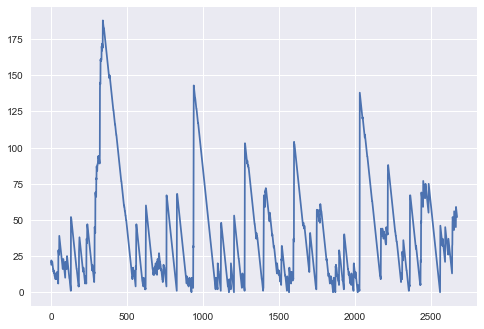

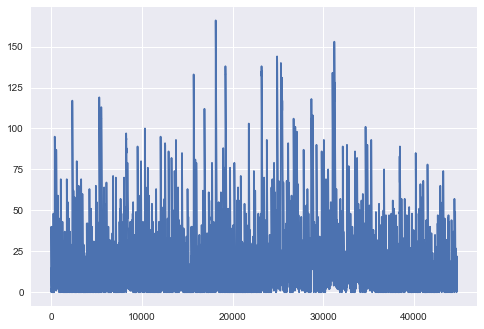

In [96]:
plt.plot(y_test)
plt.show()
plt.plot(target_TrueTest)
plt.show()

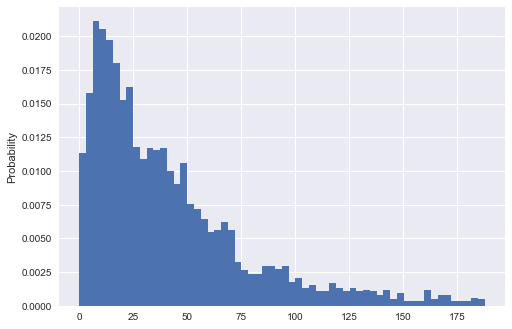

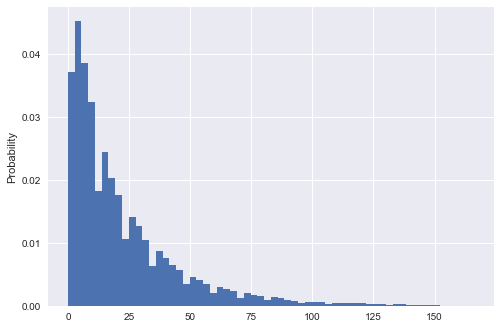

In [97]:
plt.hist(y_test, normed=True, bins=60)
plt.ylabel('Probability')
plt.show()
plt.hist(target_TrueTest, normed=True, bins=60)
plt.ylabel('Probability')

plt.show()

# Benchmark the neuron with a simpler model from sklearn, am I still overfitting the test set ? How come !!


In [98]:
from sklearn.metrics import mean_absolute_error

In [99]:
from sklearn.ensemble import RandomForestRegressor

In [100]:
myModel_backtest1 = RandomForestRegressor(n_estimators = 30, n_jobs=3, max_depth=4)
myModel_backtest1.fit(x_train, y_train)
print(mean_absolute_error(y_train,myModel_backtest1.predict(x_train)),mean_absolute_error(target_TrueTest,myModel_backtest1.predict(WaitingTimeAndTrade_TrueTest)))

C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


14.011328745695723 15.594158146492688


In [101]:
from sklearn.linear_model import ElasticNet

In [102]:
myModel_backtest2 = ElasticNet()
myModel_backtest2.fit(x_train, y_train)
print(mean_absolute_error(y_train,myModel_backtest2.predict(x_train)),mean_absolute_error(target_TrueTest,myModel_backtest2.predict(WaitingTimeAndTrade_TrueTest)))

17.501289416064516 13.66705018015773


In [103]:
from sklearn.neural_network import MLPRegressor

In [104]:
myModel_backtest3 = MLPRegressor(hidden_layer_sizes=(30,10,5))
myModel_backtest3.fit(x_train, y_train)
print(mean_absolute_error(y_train,myModel_backtest3.predict(x_train)),mean_absolute_error(target_TrueTest,myModel_backtest3.predict(WaitingTimeAndTrade_TrueTest)))

C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


24.809909034212833 17.401291452292007


C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
